### Extracting NDVI coordinates for North America
<b>Author: Ryan Gan</b>

<b>Date: 2018-05-28</b>

Extracting gridded normalized difference vegetation index values to North American region from NOAA. It is a basic measurement for measuring the greenness of the Earth. A reasonable estimation of the density and coverage of green vegetation can be determined by measuring how green the earth's surface is.

NDVI values range from -.1 to .703 and are unitless. Values greater than .1 generally denote increasing degrees in the greeness and intensity of vegetation. Values between 0 and .1 are commonly characteristic of rocks and bare soil, and values less than 0 sometimes indicate clouds, rain, and snow.

NOTE: Low values of NDVI do not necessarily denote lack of vegetation. For example, during the winter months deciduous forests may appear more orange than green.

http://www.ospo.noaa.gov/Products/land/gvi/NDVI.html

In [65]:
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
# reading in netcdf
from netCDF4 import Dataset 
# interpolate griddate
from scipy import interpolate
# import numpy as np; for working with array data
import numpy as np
# import pandas as pd; working with data.frames
import pandas as pd
# Matplotlib for additional customization
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Open connection to 2018-06-04  NDVI.

In [9]:
ndvi_nc = Dataset("../data/ndvi/AVHRR-Land_v004-preliminary_AVH13C1_NOAA-19_20180604_c20180605095501.nc")

Print out summary stats.

In [10]:
print(ndvi_nc)
# print out details of each variable
for v in ndvi_nc.variables:
    print(ndvi_nc.variables[v])

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Normalized Difference Vegetation Index parameters derived from NOAA-19 GAC data for day 2018/155
    institution: NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-LAND > MODIS Land Science Team, Terrestrial Information Systems,  Hydrospheric and Biospheric Science Laboratory, Earth Sciences Division, Science and Exploration Directorate, Goddard Space Flight Center, NASA
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v25, 05 July 2013)
    naming_authority: gov.noaa.ncdc
    license: No constraints on data access or use
    cdm_data_type: Grid
    time_coverage_start: 2018-06-04T00:00:00Z
    time_coverage_end: 2018-06-04T23:59:00Z
    product_version: v4r0-preliminary
    platform: NOAA-19 > National Oceanic & Atmospheric Administration-19
    sensor: AVHRR > Advanced Very High Resolution Radiometer
    keywords_

Extract variables.

In [13]:
# extract latitude
lat = ndvi_nc.variables['latitude'][:]
# extract longitude
lon = ndvi_nc.variables['longitude'][:]
# extract time
time = ndvi_nc.variables['time'][:]
# 1st temperature values
ndvi = ndvi_nc.variables['NDVI'][0,:,:]
# check dimension of shape
np.shape(ndvi)

(3600, 7200)

Print out min, mean, and max NDVI value.

In [14]:
print(np.min(ndvi), np.mean(ndvi), np.max(ndvi))

(-0.94950000000000001, 0.15653522147887386, 0.99640000000000006)


Subset array to bounding box of the US.

In [15]:
np.min(lon), np.max(lon)

(-179.97501, 179.97501)

In [115]:
# lat and lon bounds
latbounds = [24.4, 49.4]
# lon bounds need to be converted from easterling to westerling to get US
lonbounds = [-124.8, -66.9]

# latitude lower and upper bounds
lat_ui = np.argmin(np.abs(lat - latbounds[0]))
lat_li = np.argmin(np.abs(lat - latbounds[1]))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(lon - lonbounds[0]))
lon_ui = np.argmin(np.abs(lon - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

(811, 1311, 1103, 2261)


Subset US NDVI.

In [116]:
# subset us lon
lon_us = lon[lon_li:lon_ui]
# subset us lat
lat_us = lat[lat_li:lat_ui]
# print dimensions
print(np.min(lon_us), np.max(lon_us), np.min(lat_us), np.max(lat_us))

(-124.825, -66.974998, 24.474998, 49.424999)


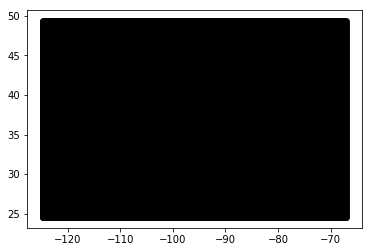

In [188]:
# extract lonlat grid
lons, lats = np.meshgrid(lon_us, lat_us)
# plot
plt.plot(lons, lats, marker='.', color='k', linestyle='none')
plt.show()

In [118]:
# subset ndvi to us
ndvi_us = ndvi_nc.variables['NDVI'][0, lat_li:lat_ui, lon_li:lon_ui]
np.shape(ndvi_us)

(500, 1158)

In [119]:
print(np.shape(lats), np.shape(lons))

((500, 1158), (500, 1158))


View heatmap of NDVI for United States for June 4th 2018.

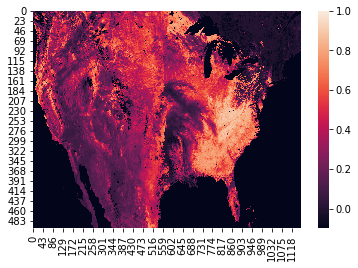

In [120]:
# view vegetation for June 6th 2016
sns.heatmap(ndvi_us, vmin = -.1, vmax=1)

Extracting latitude and longitude coordinats.

In [22]:
# coordinates to a 2 dimension array
ndvi_grid = np.array(np.meshgrid(lon_us, lat_us)).reshape(2, -1).T
# check dimensions
np.shape(ndvi_grid)

(579000, 2)

### Creating custom 1x1 degree grid

I'm going to make a slightly larger grid to reduce the size of this dataset.

Create new coarse grid latitude and longitude array.

In [223]:
# custom grids for every degree
# vectors
grid_lat = np.arange(np.min(lat_us), np.max(lat_us), 1)
grid_lon = np.arange(np.min(lon_us), np.max(lon_us), 1)
# mesh grid array
glons, glats = np.meshgrid(grid_lon, grid_lat)

Plot new grid to check out shape.

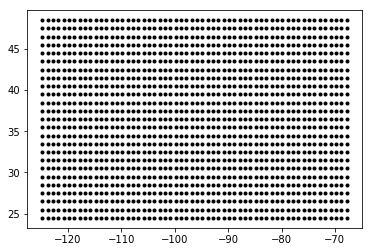

In [222]:
# plot new grid
plt.plot(glons, glats, marker='.', color='k', linestyle='none')
plt.show()

Set up interpoloation spline using RectBivariateSpline, which is faster than interp2D if it's a regular grid (which it is). Lats and Lons need to be sorted and the dimensions need to match shape of value array (ndvi).

In [224]:
# set up interp spline, coordinates need to be 1D arrays, and match the shape of the 3d array.
interp_spline = interpolate.RectBivariateSpline(sorted(lat_us), lon_us, ndvi_us)

Interpolate the NDVI values from the find grid to coarse grid.

In [225]:
# interpolate to new grid
ndvi_coarse = interp_spline(grid_lat, grid_lon)

Check shape of new coarse grid.

In [226]:
# shape of coarse grid
np.shape(ndvi_coarse)

(25, 58)

Plot the new heatmap of the reshaped grid.

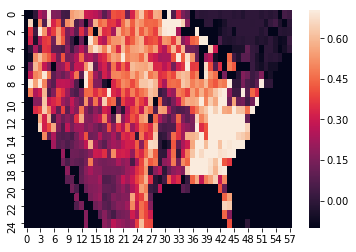

In [227]:
sns.heatmap(ndvi_coarse, vmin = -0.1, vmax = 0.703)

### Notes:

Some values are masked values (i.e. ocean, clouds, ice, etc.), only valid ranges are from -0.1 to 0.703. For example, south east Canada should be green just like a lot of the north east US. It's also summer, so there shouldn't be ice. Perhaps clouds? I'll have to look at the values. It may be okay if I average each month.

Now I want to find a way to iterate over every year and average every month. I think I might limit my pulls from 2000 to 2018 if possible.

https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/